# Text Generation

This project is associated with generating text using markov chains and look up table to generate text using different approachs at character and word level embeddings.

Contents:

1. [Probabilistic Approach](#Probabilistic-Approach)
2. [Single Layer Neural Network](#Single-Layer-Neural-Network-Approach)
3. [3 Layer Neural Network](#Multi-Layer-Perceptron-Approach)
4. [Word Level Embeddings](#Word-Level-Embedding)

# Probabilistic Approach

In [1]:
import torch
import torch.nn.functional as F
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
text = open('input.txt', 'r').readlines()

In [3]:
X = [x for x in text]

In [4]:
chars = set(list(''.join(X)))
print(chars)

{'Q', 'f', 'n', 'z', '.', 'L', 's', '-', 'c', 'm', 'I', 'w', 'M', '&', 'X', '!', 'b', 'K', 'j', "'", 'J', 'v', 'Z', 'x', ',', '3', ';', 'u', 'E', 'l', 'e', 'd', 'R', 'O', ':', 't', 'k', 'W', 'D', 'H', ' ', 'T', 'g', '?', 'r', '\n', 'F', 'U', 'C', 'o', 'y', 'S', 'i', 'G', 'h', 'V', 'A', 'B', 'Y', 'N', 'p', '$', 'P', 'a', 'q'}


In [5]:
num_chars = len(set(list(''.join(X))))
num_chars += 1 # for special token
num_chars

66

There are total 66 characters

In [6]:
chars = sorted(chars)
print(chars)

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [7]:
chtoi = {ch:i+1 for i, ch in enumerate(chars)}
chtoi['<c>'] = 0
itoch={i:ch for ch, i in chtoi.items()}

In [8]:
counts = {}
for sample in X:
    s_ = list(sample)
    for ch1, ch2 in zip(s_, s_[1:]):
        bigram = (ch1, ch2)
        counts[bigram] = counts.get(bigram, 0)  + 1

In [9]:
# most common bigrams

sorted(counts.items(), key = lambda kv: -kv[1])[:5]

[(('e', ' '), 27643),
 ((' ', 't'), 23837),
 (('t', 'h'), 22739),
 (('h', 'e'), 18203),
 (('t', ' '), 16508)]

In [10]:
len(counts)

1351

We have 1351 pairs of characters

In [11]:
# creating counts table

N = torch.zeros((num_chars, num_chars), dtype=torch.int32)
for bigram, count in counts.items():
    ch1, ch2 = bigram
    idx1, idx2 = chtoi[ch1], chtoi[ch2]
    N[idx1, idx2] = count

In [12]:
# creating probabilities table

N = N+1 # model smoothning
P = torch.zeros(N.shape)
for i in range(num_chars):
    p = N[i].float()
    p = p / p.sum()
    p = p.view(1, num_chars)
    P[i] = p

## Note

Here `P` is a look-up table which contains the probability of the next character that can come given the current character. `P` is derived from `N` which has counts of all the bigrams observed in the text.

In [16]:
# generating text from probabilities table

char_g = 500
idx = 0
gen_text = ''
for _ in range(char_g):
    p = N[idx].float()
    p = p / p.sum()
    idx = torch.multinomial(p, num_samples=1, replacement=True).item() # .item() to convert a tensor to python scaler
    if itoch[idx] == '<d>':
        break
    gen_text += itoch[idx]
print(gen_text)

TIOFICHBr:
hithak ingnse,
DY:
mbas le ike ons wheriga'd'dyoure,
D t,
ENoce dsooet, ns akis Bun ga.
hasthus IR:
impe weate hing nguand wegudrn IUSe ge.
k angr talot minct, wond y an thy tho oree ayovo k; ous aporarle prod att
RLLIng 'l!
:
VIORI'sheend aishent f n desoudes ghereraldothurureag yoou wngak dlmifo oran hf m, RI he
pon wit, haresaystheonind me hare Maborome we!
Whay bonared ororareailau stas for hare urare;
y ny fond the o w'totrat m. the chaugea I u INIfoks istiont;
Wouk
!'Thendllat h


In [17]:
print(f'Loss of the model: {-P.log().mean()}')

Loss of the model: 6.949477672576904


### Conclusion
The model works on just probablities and generates very bad text.

# Single Layer Neural Network Approach

In [19]:
# creating training set

xs = []
ys = []

for sample in X:
    s_ = list(sample)
    for ch1, ch2 in zip(s_, s_[1:]):
        ix1 = chtoi[ch1]
        ix2 = chtoi[ch2]

        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

print(f'{xs.shape=}')
print(f'{ys.shape=}')

xs.shape=torch.Size([1075394])
ys.shape=torch.Size([1075394])


In [23]:
# encoding X

xs_enc = F.one_hot(xs, num_classes=num_chars).float()
print(f'{Xenc.shape=}')

Xenc.shape=torch.Size([1075394, 66])


In [25]:
epochs = 100_000
num_examples = xs.shape[0]

#initializing the layer
W = torch.randn((num_chars, num_chars)) * 0.1
W.requires_grad = True

lossi = [] # to track the loss

In [26]:
# training the network

for k in range(epochs):
    ix = torch.randint(0, num_examples, (32,)) # training on 32 examples
    x, y = xs_enc[ix], ys[ix]

    # forward pass
    logits = x @ W
    loss = F.cross_entropy(logits, y) 

    # backward pass
    W.grad = None
    loss.backward()

    #update
    lr = 0.1 if k < epochs // 2 else 0.01
    W.data += -lr * W.grad

    lossi.append(loss.item())
print(f'Initial loss       : {lossi[0]}')
print(f'After training loss: {lossi[-1]}')

Initial loss       : 4.215484142303467
After training loss: 2.290081024169922


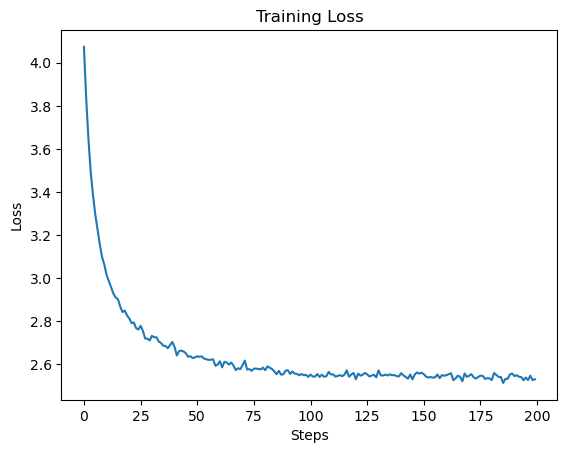

In [28]:
plt.title('Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
lossi_tensor = torch.tensor(lossi).view(-1, 500).mean(1)
plt.plot(lossi_tensor);

In [31]:
# generating from the network trained

idx = 0
gen_text = ''
for _ in range(500):
    xenc = F.one_hot(torch.tensor([idx]), num_classes=num_chars).float()
    logits = xenc @ W
    counts = logits.exp()
    p = counts / counts.sum(1, keepdims = True)
    idx = torch.multinomial(p, num_samples=1, replacement=True).item()
    gen_text += itoch[idx]
print(gen_text)

-fo e gHy b?
Zlar sio RH:
$llooe lor,
therelot k3XG.
, ad,
;
!
-marghenl waroue be prelle:
r?
f hay bea core $FRve philinchejK'd&k mas matis wes wered' pyHAhit, m<c>; tore
3I tote s dot the llay o aper ula Vy hthyqq-ceramy keyE&: me ; ind
Yx
PV; IOD's m mBk m misQgbe t: eB<c>veithanysurean'?kil w s, thiro whie Iy d hy ineno GX's k hindens d home, t I dse blefous;
ou s f t we athoVkMq?
3jenerdoth; aivenori t flle ethouthaithad at sq$m he de.
e pitr, ycind nous age bee, fmpINx;
MbimerDQHWh t atho thed


### Conclusion:
The model gets trained on on data throught forward pass and backpropagation, eventually learning something and decreasing the loss.

We can see the model generated some meaningful words. But a lot of words that are generated are not meaningful. A lot of improvement has to be made.

# Multi-Layer Perceptron Approach

In [32]:
#loading dataset

context_size = 3
xs, ys = [], []

for x in X:
    context = [0] * context_size
    
    for i, ch in enumerate(list(x)):
        ix = chtoi[ch]
        xs.append(context)
        ys.append(ix)

        context = context[1:] + [ix] # cropping and appending context

xs = torch.tensor(xs)
ys = torch.tensor(ys)

print(f'{xs.shape=}')
print(f'{ys.shape=}')

xs.shape=torch.Size([1115394, 3])
ys.shape=torch.Size([1115394])


In [33]:
# train, dev, test split

xs_train, xs_rest, ys_train, ys_rest = train_test_split(xs, ys, test_size = 0.2, random_state = 42)
xs_dev, xs_test, ys_dev, ys_test = train_test_split(xs_rest, ys_rest, test_size = 0.5, random_state = 42)

In [34]:
print(f'{xs_train.shape=}')
print(f'{xs_dev.shape=}')
print(f'{xs_test.shape=}')
print('---')
print(f'{ys_train.shape=}')
print(f'{ys_dev.shape=}')
print(f'{ys_test.shape=}')

xs_train.shape=torch.Size([892315, 3])
xs_dev.shape=torch.Size([111539, 3])
xs_test.shape=torch.Size([111540, 3])
---
ys_train.shape=torch.Size([892315])
ys_dev.shape=torch.Size([111539])
ys_test.shape=torch.Size([111540])


In [63]:
# initializing

emb_dim = 5
n_hidden = 200

C = torch.randn((num_chars, emb_dim))
W1 = torch.randn((context_size * emb_dim, n_hidden)) * (5/3) / ((context_size * emb_dim) ** 0.5)
b1 = torch.randn(n_hidden) * 0.01 
W2 = torch.randn((n_hidden, num_chars)) * 0.1
b2 = torch.randn(num_chars) * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

lossi = []

In [64]:
print(f'Number of Parameters: {sum(p.nelement() for p in parameters)}')

Number of Parameters: 16796


In [46]:
epochs = 200000

for k in range(epochs):
    ix = torch.randint(0, xs_train.shape[0], (32,))

    # forward pass
    emb_ = C[xs_train[ix]].view(-1, context_size * emb_dim)
    h_pre = emb_ @ W1 + b1
    h = torch.tanh(h_pre)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, ys[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if k < epochs // 2 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    lossi.append(loss.item())

print(f'Initial loss: {lossi[0]}')
print(f'After training loss: {lossi[-1]}')

Initial loss: 4.6018805503845215
After training loss: 3.5252017974853516


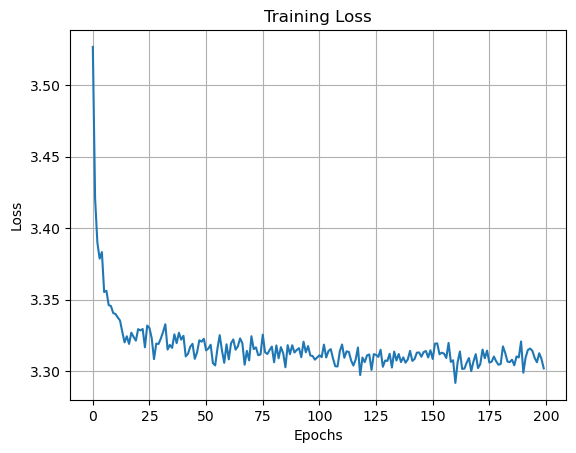

In [49]:
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid('micro')
lossi_tensor = torch.tensor(lossi).view(-1, 1000).mean(1) 
plt.plot(lossi_tensor);

In [50]:
# validation loss

with torch.no_grad():
    emb = C[xs_dev].view(-1, context_size * emb_dim)
    h_pre = emb @ W1 + b1 
    h = torch.tanh(h_pre)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, ys_dev)
    print('Validation Loss: ',loss.item())

Validation Loss:  3.312225103378296


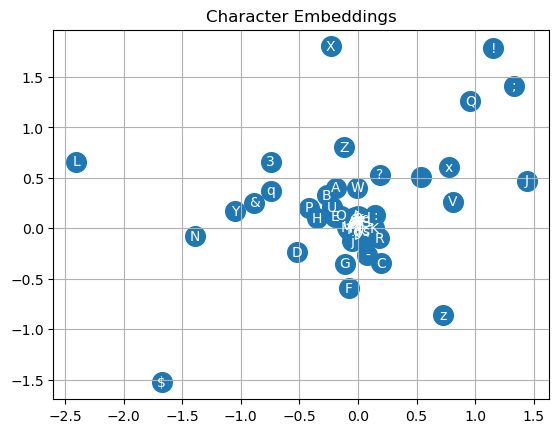

In [51]:
plt.title('Character Embeddings')
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itoch[i], ha='center', va='center', color='white')
plt.grid('micro');

In [53]:
# sampling from the model

output = []
context = [0] * context_size

for _ in range(500):
    emb = C[torch.tensor([context])].view(1, -1)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    output.append(ix)

print(''.join(itoch[i] for i in output))

uH tud
 l A coe I 
sSi
'nnoay?o
itaei
Wg oep oef o
Ioo.IDKhedrLte,ovez
o.e Faom
 a  hs trs,vy IAwpaIb?rH ra aIsemk
e
g iwhR
 sluis:reoSdGyByddes oett mfan-R usl en , ;'ighkycfybl hsnLo.ne bemabmmaBY,t:eyal o
ahRt
  hHyIlSn e
eaRln
us 
uw tihf lh rl C  tatwd haathe,so  rd'
uahetuh tiyoeupytdIre
s,onse Htna,Ne,etoea dra
p

tSphl hAtduheondbhh
mic esL  ,htl eGTri gi: nifsnbsase Au G ro  ly traeeTs:ssh fl eL,SifdUme pesiruoth  'o,F<c>ysut.sgteaswle, 
aaosuegs T  eeiLcoo  taddln AhTttrLrh hiadeeeee opt


### Conclusion

Not a good network. Much more improvements need to be done.

# Word Level Embedding

In [54]:
corpus = ''.join(text)
dialogs = corpus.split('\n\n')

In [55]:
#cleaning text

for i, d in enumerate(dialogs):
    t = d.replace('\n', ' ')
    pattern = r"[^\w\s:]"
    t = re.sub(pattern, '', t)
    t = t
    dialogs[i] = t

In [56]:
text_corpus = ' '.join(dialogs)
vocab = set(text_corpus.split())
vocab = sorted(vocab) # sorting the vocab
vocab_size = len(vocab) + 1

print(f'Vocabulary Size: {vocab_size}')

Vocabulary Size: 16117


In [58]:
# tokenizer dictionaries

wtoi = {w:i+1 for i, w in enumerate(vocab)}
wtoi['<s>'] = 0
itow = {i:w for w, i in wtoi.items()}

In [59]:
# loading dataset

context_size = 3
xs, ys = [], []

for s in dialogs:
    context = [0] * context_size
    
    for w in s.split() + ['<s>']:
        ix = wtoi[w]
        xs.append(context)
        ys.append(ix)

        context = context[1:] + [ix] # cropping and appending context

xs = torch.tensor(xs)
ys = torch.tensor(ys)

print(f'{xs.shape=}')
print(f'{ys.shape=}')

xs.shape=torch.Size([209870, 3])
ys.shape=torch.Size([209870])


In [67]:
# initializing

emb_dim = 5
n_hidden = 200

C = torch.randn((vocab_size, emb_dim))
W1 = torch.randn((context_size * emb_dim, n_hidden)) * (5/3) / ((context_size * emb_dim) ** 0.5)
b1 = torch.randn(n_hidden) * 0.01 
W2 = torch.randn((n_hidden, vocab_size)) * 0.1
b2 = torch.randn(vocab_size) * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

lossi = [] # to track loss

In [68]:
print(f'Number of Parameters: {sum(p.nelement() for p in parameters)}')

Number of Parameters: 3323302


In [69]:
epochs = 100000

for k in range(epochs):
    ix = torch.randint(0, xs.shape[0], (32,))

    # forward pass
    emb_ = C[xs_train[ix]].view(-1, context_size * emb_dim)
    h_pre = emb_ @ W1 + b1
    h = torch.tanh(h_pre)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, ys[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.3 if k < epochs // 2 else 0.03
    for p in parameters:
        p.data += -lr * p.grad

    lossi.append(loss.item())

print(f'Initial loss: {lossi[0]:.3f}')
print(f'After training loss: {lossi[-1]:.3f}')

Initial loss: 10.123
After training loss: 6.954


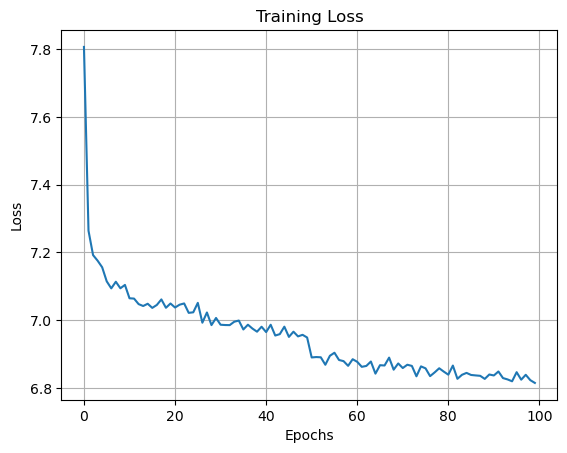

In [70]:
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid('micro')
lossi_tensor = torch.tensor(lossi).view(-1, 1000).mean(1) 
plt.plot(lossi_tensor);

In [72]:
output = []
context = [0] * context_size

for _ in range(50):
    emb = C[torch.tensor([context])].view(1, -1)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    output.append(ix)

op = ' '.join(itow[i] for i in output)
print(op.replace('<s>', '\n'))

will dost mirror white hangman: where amazement: troops Art underneath Aves prove Caesar Gentlemen coverd so Will brother be Ready false model deliver You 
 heir mulberry of seven their rascals cunning Proserpina child thing endeavours Being and your Kate against meanborn policy ashore nose dread him night curbs George


## Conclusion

Not generating meaningful text. Maybe the network has not reached the minimum.